In [1]:
import pandas as pd
import numpy as np

import os
import pickle

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder

import xgboost as xgb

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Bidirectional, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.utils import np_utils
from keras.utils import plot_model

from PIL import Image

import matplotlib.pyplot as plt



Using TensorFlow backend.


In [2]:
base_folder = "Data for ML Project"
project_folder = "Batch 3 Quantile Ranking"
batch = "Batch3"

if not os.path.exists(batch):
    os.mkdir(batch)
    
total_data, labels = [], []

for file in sorted(os.listdir(os.path.join(base_folder, project_folder))):
    df = pd.read_csv(os.path.join(base_folder, project_folder, file))
    total_data.append(df.fillna(value=0).drop(columns=["ticker", "returns"]).values.tolist())
    labels.append(df["returns"].values.tolist())
    
total_data = np.array(total_data)
labels = np.array(labels)

print(total_data.shape, labels.shape)

(52, 505, 131) (52, 505)


In [3]:
dfs = []
for file in sorted(os.listdir(os.path.join(base_folder, project_folder))):
    df = pd.read_csv(os.path.join(base_folder, project_folder, file))
    dfs.append(df.fillna(value=0))
    
combined_df = pd.concat(dfs)
combined_df.head()

,ticker,SQN_Q1_CI,SQN_Q2_CI,SQN_Q3_CI,SQN_Q4_CI,SQN_Q1,SQN_Q2,SQN_Q3,SQN_Q4,IV_calls_0,...,zomma_puts_180,speed_puts_180,color_puts_180,dual_delta_puts_180,dual_gamma_puts_180,IV_0,IV_30,IV_120,IV_180,returns
0,A,1.0,2.0,5.0,4.0,1.0,2.0,5.0,4.0,2.0,...,4.0,4.0,4.0,3.0,2.0,2.0,3.0,2.0,2.0,1.0
1,AAL,2.0,4.0,4.0,1.0,3.0,4.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,AAP,5.0,1.0,1.0,2.0,5.0,1.0,1.0,2.0,3.0,...,2.0,2.0,2.0,4.0,4.0,3.0,1.0,3.0,3.0,-1.0
3,AAPL,1.0,1.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,...,1.0,2.0,1.0,4.0,5.0,2.0,2.0,2.0,2.0,-1.0
4,ABBV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0


## Plotting Correlation Matrix

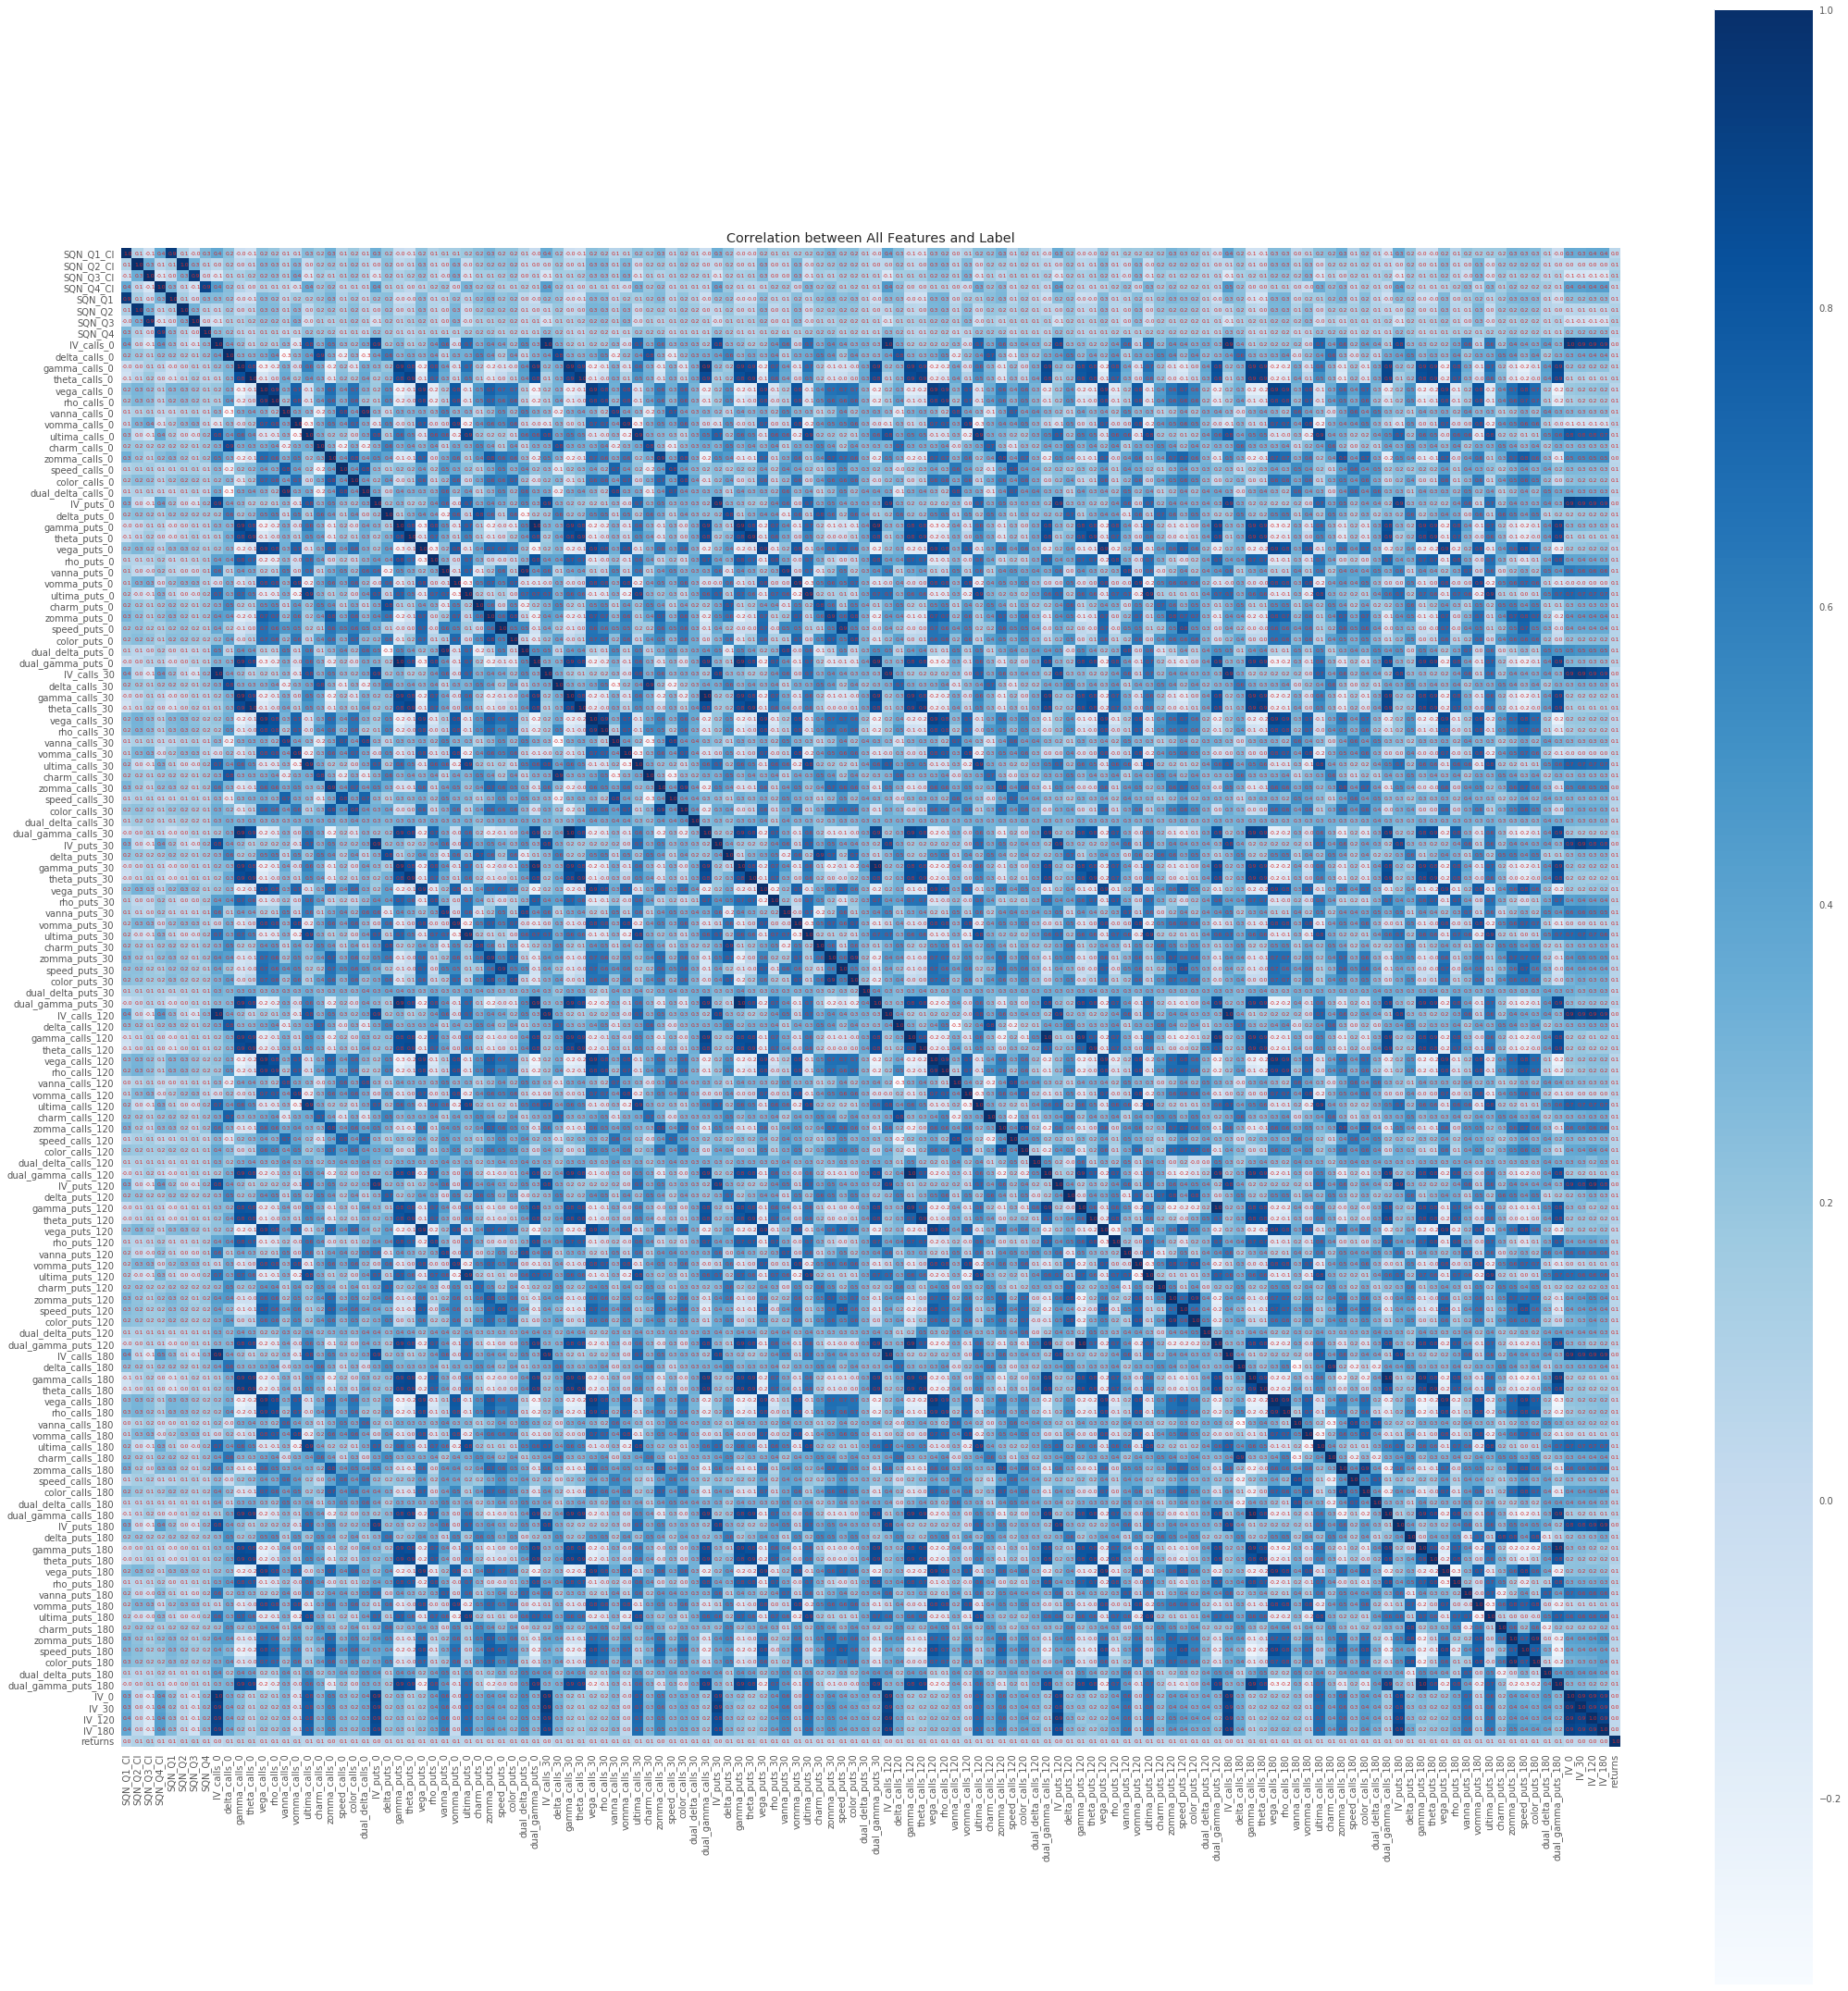

In [4]:
def plot_correlation_matrix(df, titl):
    plt.imshow(df.values, cmap=plt.cm.Blues)
    plt.xticks(range(df.shape[0]), df.columns, rotation='vertical')
    plt.yticks(range(df.shape[0]), df.columns)
    plt.title(titl)
    plt.colorbar()
    plt.grid(None)
    for i in range(0,df.shape[0]):
        for j in range(0, df.shape[0]):
            if df.values[i, j] < 0:
                plt.text(i-0.4, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=6);
            else:
                plt.text(i-0.3, j+0.1, '%.1f'%df.values[i, j], color='tab:red', fontsize=6);
                
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(30,30))
    plot_correlation_matrix(combined_df.drop(columns=["ticker"]).corr(), 'Correlation between All Features and Label')
                
    plt.tight_layout()
    
    plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
    
    plt.savefig(os.path.join(batch,"correlation.png"), dpi=200)


## P-values and F-values For Classification

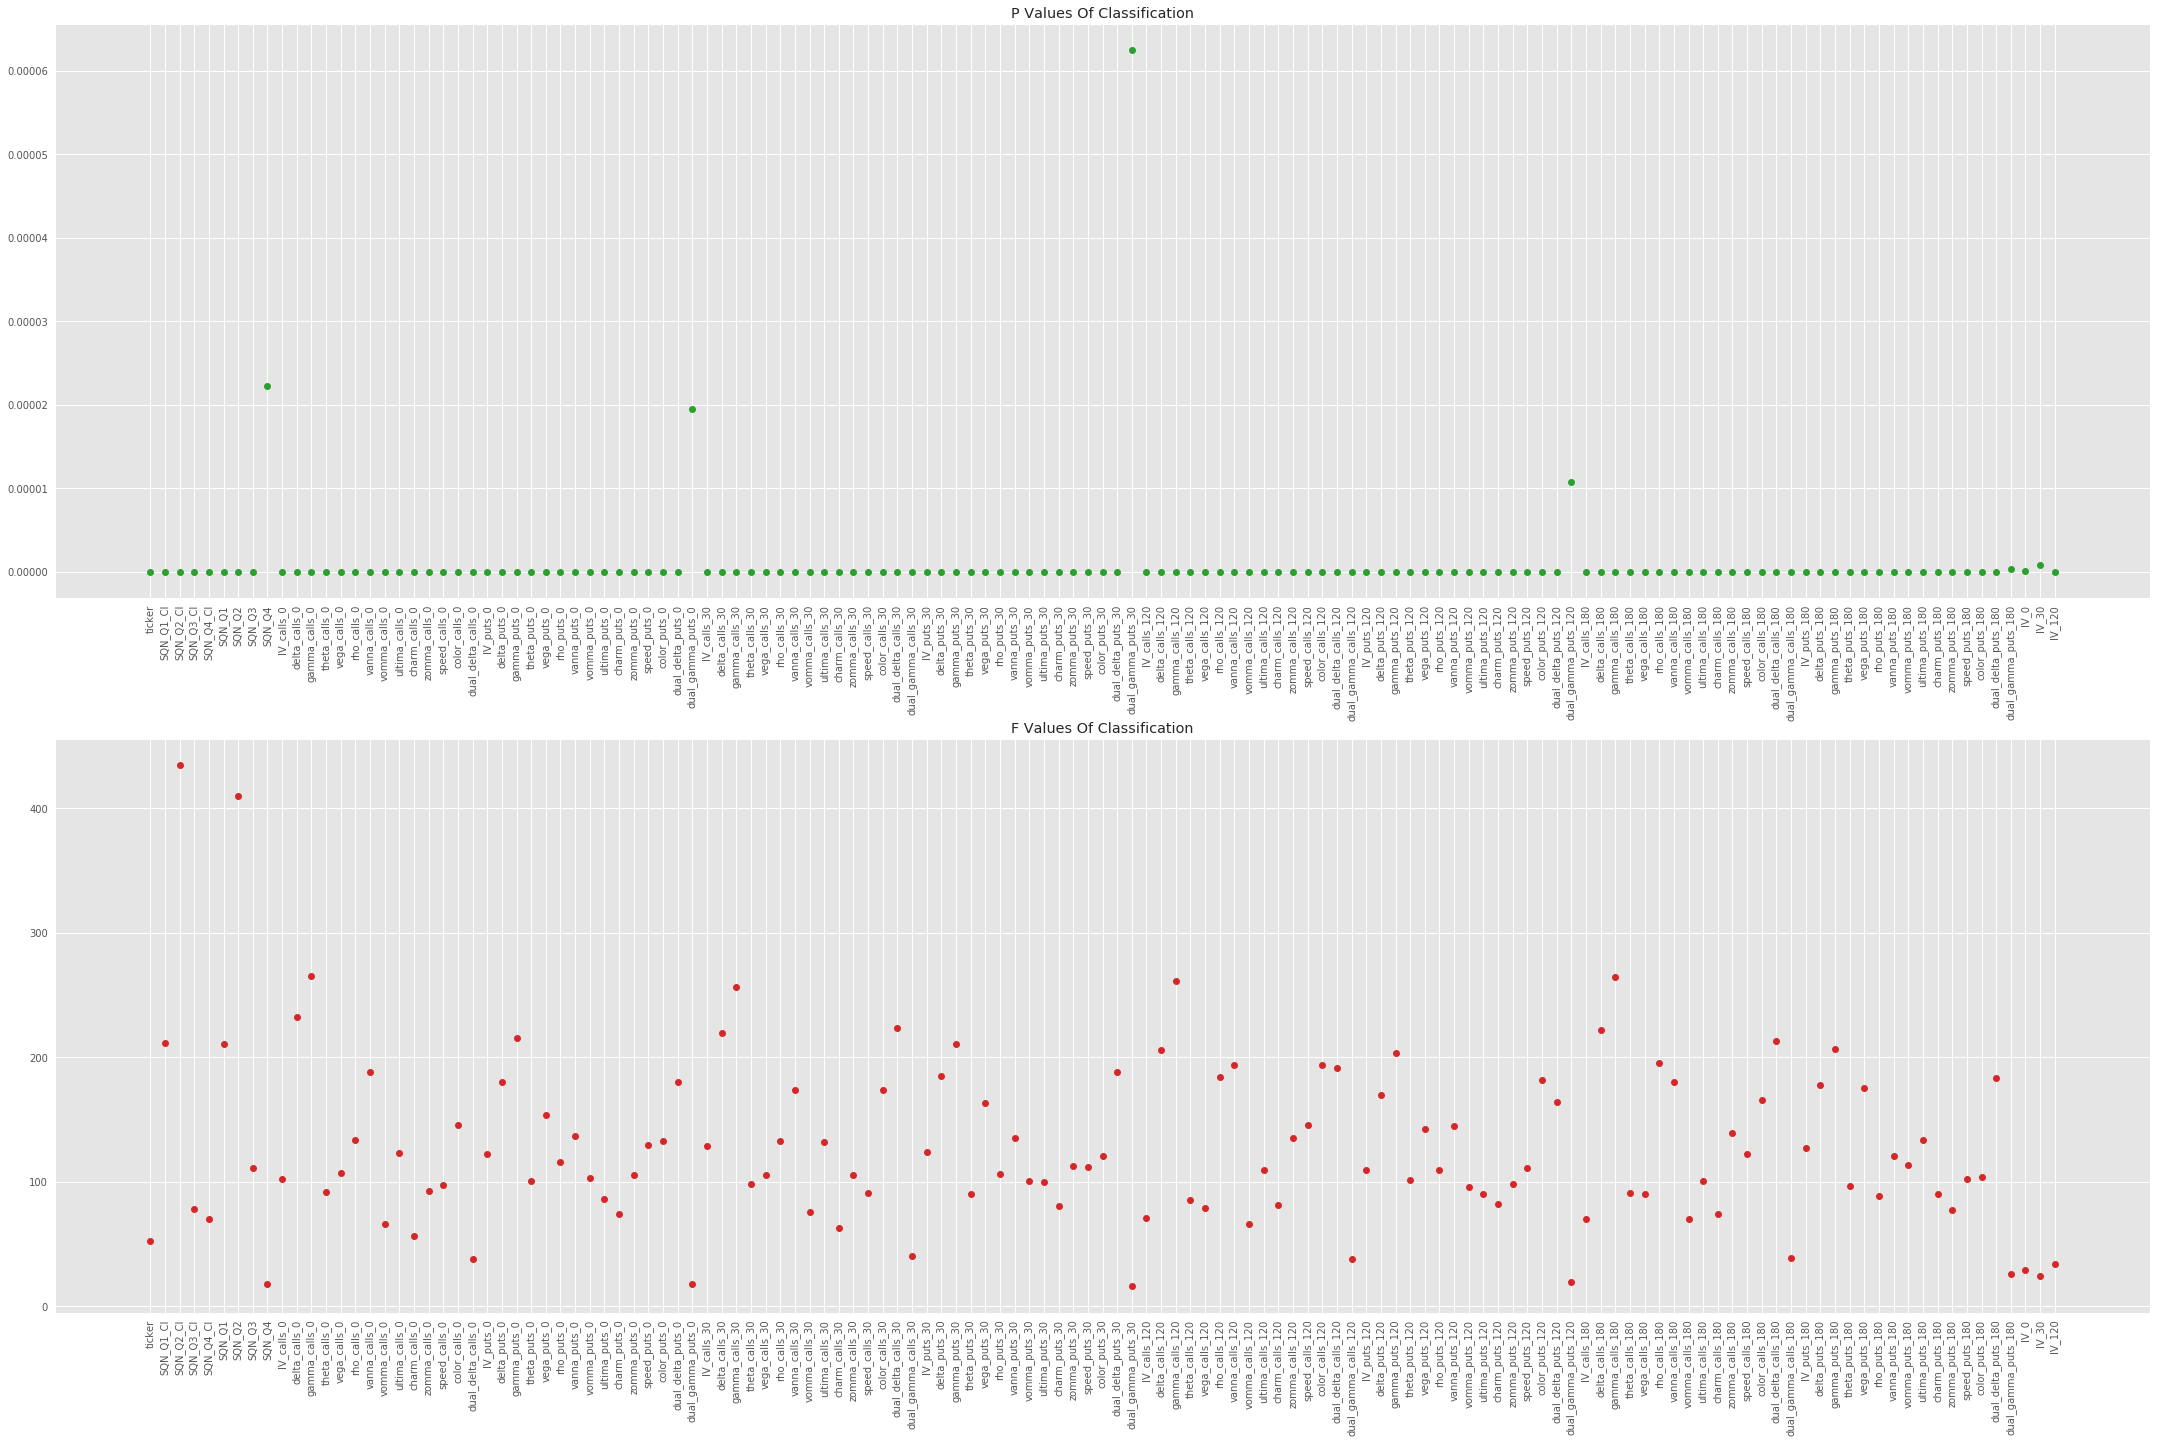

In [5]:
X = combined_df.drop(columns=["ticker","returns"])
X = MinMaxScaler().fit_transform(X)
Y = combined_df['returns'].values
Y = np.array([1 if y==1 else 0 for y in Y])

cols = combined_df.drop(columns=["returns"]).columns

F_classif, p_value_classif = f_classif(X, Y)

with plt.style.context(('seaborn', 'ggplot')):
    plt.figure(figsize=(30,20))
    plt.subplot(211)
    plt.plot(p_value_classif, 'o', c = 'tab:green')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('P Values Of Classification')
    plt.subplot(212)
    plt.plot(F_classif, 'o', c = 'tab:red')
    plt.xticks(range(X.shape[1]), cols, rotation='vertical')
    plt.title('F Values Of Classification');
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(batch,"f_p_values.png"), dpi=200)

In [6]:
def plot_confusion_matrix(actuals, preds):
    conf_mat = confusion_matrix(actuals, preds)
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(10,10))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.xticks([0, 1], [-1, 1])
        plt.yticks([0, 1], [-1, 1])
        plt.grid(None)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')
            
            
def print_plot_metrics(model_name, Y_test, predictions):
    print('Classification Report : \n',classification_report(Y_test, predictions))
    print('Confusion Matrix : \n', confusion_matrix(Y_test, predictions))
    plot_confusion_matrix(Y_test, predictions)
    
    
def print_weights_per_layer(model):
    weights = model.get_weights()
    layers = [layer for layer in model.layers if layer.__class__.__name__ != 'Dropout']

    i = 0
    for layer in layers:
        if layer.__class__.__name__ =='Dense':
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            print('Layer : %s : Bias : %s'%(layer.__class__.__name__, weights[i+1].shape))
            i = i+2
        else:
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            i = i+1

## 1. Dense Net V1

### Data Preparation

In [7]:
total_data, labels = [], []

for file in sorted(os.listdir(os.path.join(base_folder, project_folder))):
    df = pd.read_csv(os.path.join(base_folder, project_folder, file))
    labels.append([1 if ret==1 else 0 for ret in df["returns"].values.tolist()])
    df = pd.get_dummies(df.fillna(value=0).drop(columns=["returns"]), columns=["ticker"])
    total_data.append(df.values.tolist())
    
    
total_data = np.array(total_data)
labels = np.array(labels)

print(total_data.shape, labels.shape)

(52, 505, 636) (52, 505)


In [8]:
X_train, X_test = total_data[:49], total_data[49:]
Y_train, Y_test = labels[:49], labels[49:]

X_train, X_val = X_train[:46], X_train[46:]
Y_train, Y_val = Y_train[:46], Y_train[46:]

X_train, X_val, X_test = X_train[:-1], X_val[:-1], X_test[:-1]
Y_train, Y_val, Y_test = Y_train[1:], Y_val[1:], Y_test[1:]

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

((45, 505, 636), (2, 505, 636), (2, 505, 636), (45, 505), (2, 505), (2, 505))

In [9]:
X = total_data[:-1].reshape((-1, total_data.shape[-1]))
Y = labels[1:].flatten()

print(X.shape, Y.shape)

X_train = X_train.reshape((-1, X_train.shape[-1]))
X_val = X_val.reshape((-1, X_val.shape[-1]))
X_test = X_test.reshape((-1, X_test.shape[-1]))

Y_train = Y_train.flatten()
Y_val = Y_val.flatten()
Y_test = Y_test.flatten()

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

(25755, 636) (25755,)


((22725, 636), (1010, 636), (1010, 636), (22725,), (1010,), (1010,))

### Model Creation

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               81536     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

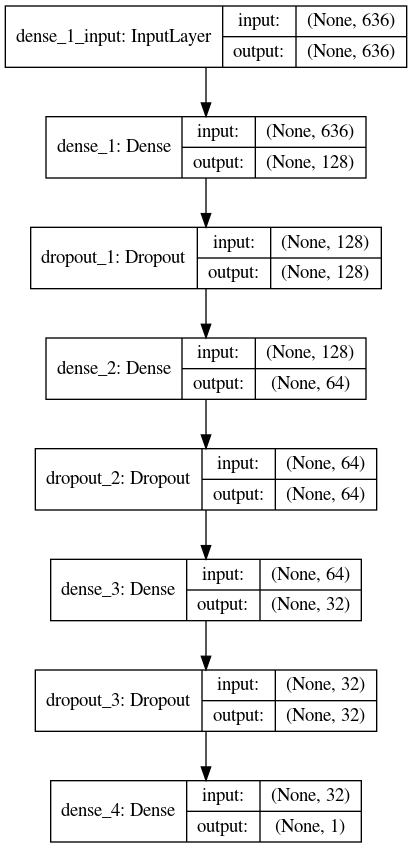

In [10]:
dense_model1 = Sequential([ 
                     Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     #BatchNormalization(),      
                     Dropout(0.2),
                     Dense(64,  activation='relu'),
                     #BatchNormalization(),  
                     Dropout(0.2),
                     Dense(32,  activation='relu'),
                     #BatchNormalization(),
                     Dropout(0.2),
                     Dense(1,   activation='sigmoid')])

print(dense_model1.summary())
plot_model(dense_model1, to_file=os.path.join(batch, 'dense1.png'), show_shapes=True)
Image.open(os.path.join(batch, 'dense1.png'))

### Model Compilation

In [11]:
dense_model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

### Model Training

In [12]:
history = dense_model1.fit(X_train, Y_train, batch_size=505, epochs=50, validation_data=(X_val, Y_val), verbose=1,shuffle=False, use_multiprocessing=True);

Train on 22725 samples, validate on 1010 samples
Epoch 1/50
22725/22725 [==============================] - 3s 112us/step - loss: 0.7132 - accuracy: 0.5178 - val_loss: 0.6915 - val_accuracy: 0.5277
Epoch 2/50
22725/22725 [==============================] - 0s 13us/step - loss: 0.6855 - accuracy: 0.5277 - val_loss: 0.6850 - val_accuracy: 0.5238
Epoch 3/50
22725/22725 [==============================] - 0s 12us/step - loss: 0.6722 - accuracy: 0.5349 - val_loss: 0.6839 - val_accuracy: 0.5158
Epoch 4/50
22725/22725 [==============================] - 0s 12us/step - loss: 0.6707 - accuracy: 0.5292 - val_loss: 0.6844 - val_accuracy: 0.5208
Epoch 5/50
22725/22725 [==============================] - 0s 12us/step - loss: 0.6704 - accuracy: 0.5274 - val_loss: 0.6845 - val_accuracy: 0.4891
Epoch 6/50
22725/22725 [==============================] - 0s 13us/step - loss: 0.6686 - accuracy: 0.5317 - val_loss: 0.6856 - val_accuracy: 0.4921
Epoch 7/50
22725/22725 [==============================] - 0s 13us/st

### Visualizing Training Results

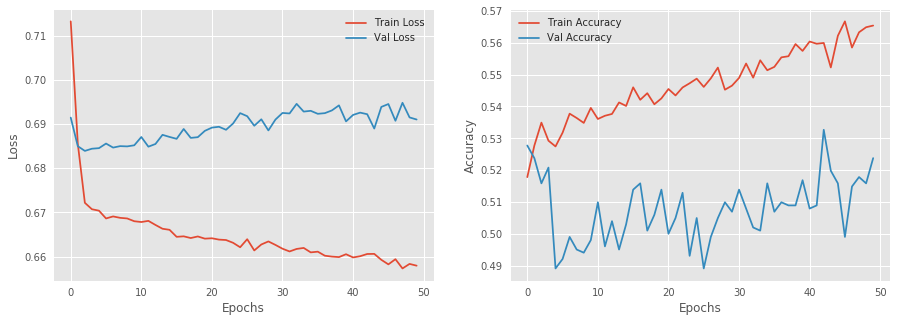

In [13]:
plot_loss_and_accuracy(history)

### Checking Accuracy On Test Data

In [14]:
predictions = dense_model1.predict_classes(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions.flatten()))

Accuracy : 0.565


In [15]:
#predictions_full = dense_model1.predict_classes(X)
#print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

In [16]:
probs = dense_model1.predict_proba(X).flatten()
probs[:10]

array([0.57454693, 0.29829735, 0.5442854 , 0.58852947, 0.20804352,
       0.57845676, 0.5282541 , 0.48052534, 0.5255651 , 0.5091128 ],
      dtype=float32)

### Printing & Visualizing Metrics

Classification Report : 
               precision    recall  f1-score   support

           0       0.51      0.46      0.49       451
           1       0.60      0.65      0.62       559

    accuracy                           0.57      1010
   macro avg       0.56      0.56      0.55      1010
weighted avg       0.56      0.57      0.56      1010

Confusion Matrix : 
 [[208 243]
 [196 363]]


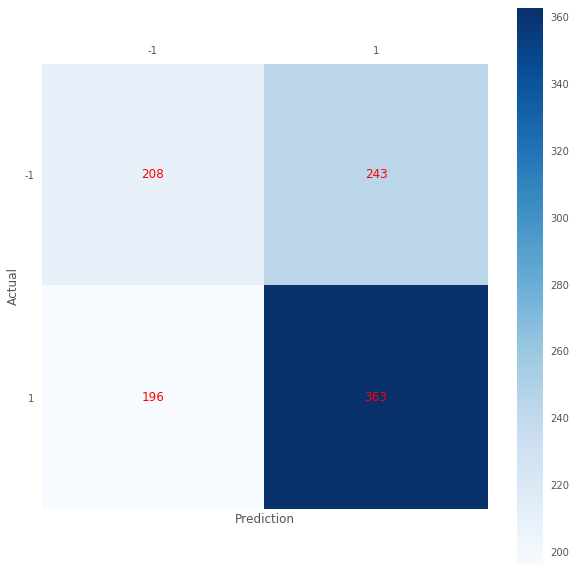

In [17]:
print_plot_metrics('DenseNetv1', Y_test, predictions.flatten())

In [18]:
print_weights_per_layer(dense_model1)

Layer : Dense : Weights : (636, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 1)
Layer : Dense : Bias : (1,)


### Visualizing Weights FOr Features

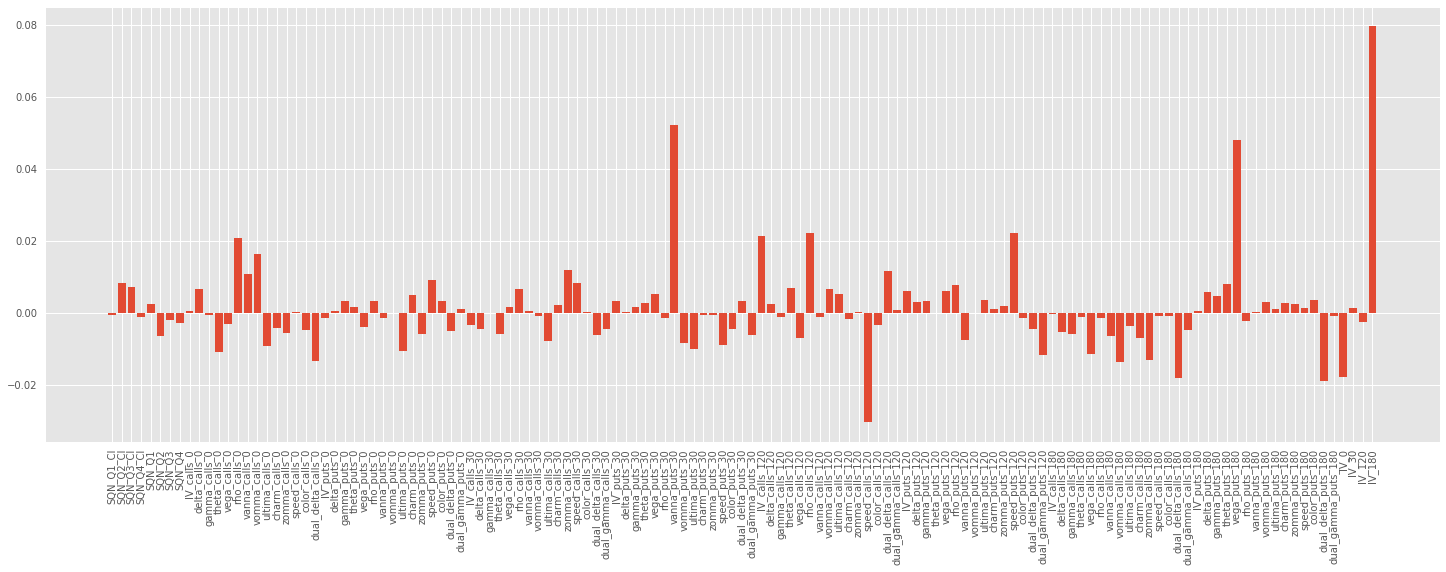

In [19]:
dense_weights = dense_model1.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[505:], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_dense_v1.png"), dpi=200)

### Saving Model & Loading From Saved File

In [20]:
dense_model1.save(os.path.join(batch,"dense_classifier_v1.h5"))

In [21]:
dense_model1 = load_model(os.path.join(batch,"dense_classifier_v1.h5"))

dense_model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               81536     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

### Future Values Prediction

In [22]:
def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    df = df.fillna(value=0)

    data = df.values
    #data = data.reshape((1, data.shape[0], data.shape[1]))

    prediction_probs = model.predict(data).flatten()
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

In [23]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, dense_model1)

probs[:5], labels[:5]

(array([0.5976973 , 0.4727553 , 0.5107761 , 0.55527407, 0.5468943 ],
       dtype=float32), array([ 1, -1,  1,  1,  1]))

### Adding Probabilities to Combined Data Frame

In [24]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, dense_model1)
    tot_probs.extend(probs)
    tot_labels.extend(labels)

combined_df_final = combined_df.copy()
combined_df_final["DenseV1_Probs"] = tot_probs
combined_df_final["DenseV1_Preds"] = tot_labels

## 2. Dense Model V2

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              1304576   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

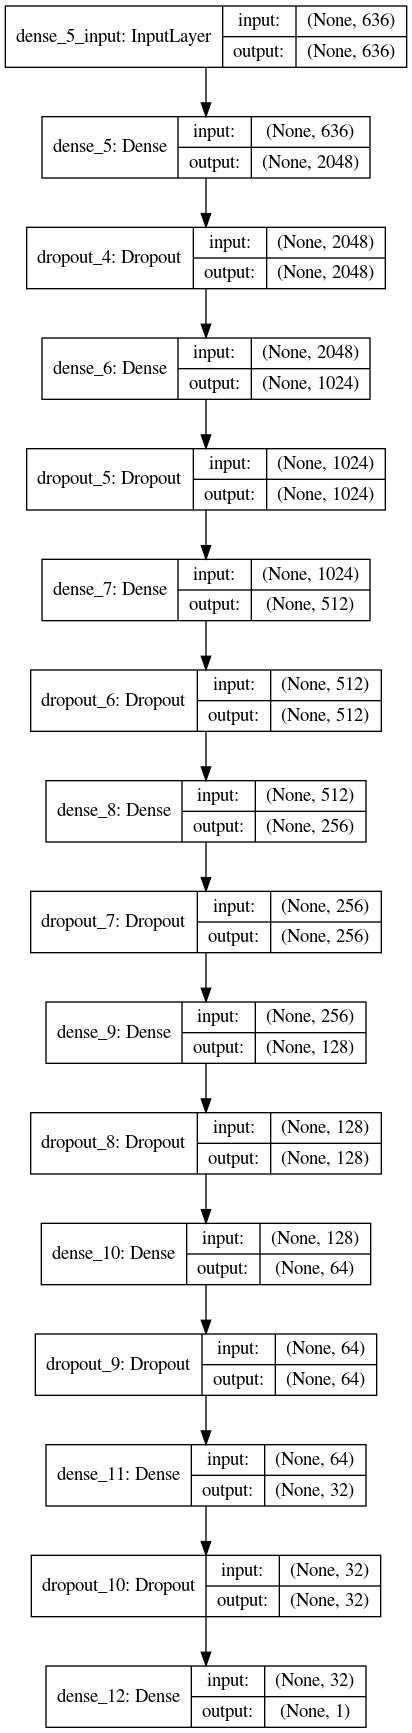

In [25]:
dense_model2 = Sequential([ 
                     Dense(2048, activation='relu', input_shape=(X_train.shape[1],)),
                     Dropout(0.3),
                     Dense(1024,  activation='relu'),
                     Dropout(0.3),
                     Dense(512,  activation='relu'),
                     Dropout(0.3),
                     Dense(256,  activation='relu'),
                     Dropout(0.3),
                     Dense(128,  activation='relu'),
                     Dropout(0.3),
                     Dense(64,  activation='relu'),
                     Dropout(0.3),
                     Dense(32,  activation='relu'),
                     Dropout(0.3),
                     Dense(1,   activation='sigmoid')])

print(dense_model2.summary())
plot_model(dense_model2, to_file=os.path.join(batch, 'dense2.png'), show_shapes=True)
Image.open(os.path.join(batch, 'dense2.png'))

In [26]:
dense_model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [27]:
history = dense_model2.fit(X_train, Y_train, batch_size=505, epochs=50, validation_data=(X_val, Y_val), verbose=1,shuffle=False, use_multiprocessing=True);

Train on 22725 samples, validate on 1010 samples
Epoch 1/50
22725/22725 [==============================] - 6s 252us/step - loss: 0.7124 - accuracy: 0.5204 - val_loss: 0.6946 - val_accuracy: 0.4931
Epoch 2/50
22725/22725 [==============================] - 5s 239us/step - loss: 0.6930 - accuracy: 0.5305 - val_loss: 0.6933 - val_accuracy: 0.4931
Epoch 3/50
22725/22725 [==============================] - 6s 253us/step - loss: 0.6868 - accuracy: 0.5284 - val_loss: 0.6854 - val_accuracy: 0.4931
Epoch 4/50
22725/22725 [==============================] - 6s 286us/step - loss: 0.6784 - accuracy: 0.5287 - val_loss: 0.6871 - val_accuracy: 0.4931
Epoch 5/50
22725/22725 [==============================] - 6s 258us/step - loss: 0.6739 - accuracy: 0.5307 - val_loss: 0.6869 - val_accuracy: 0.4931
Epoch 6/50
22725/22725 [==============================] - 6s 263us/step - loss: 0.6735 - accuracy: 0.5295 - val_loss: 0.6870 - val_accuracy: 0.4931
Epoch 7/50
22725/22725 [==============================] - 6s 28

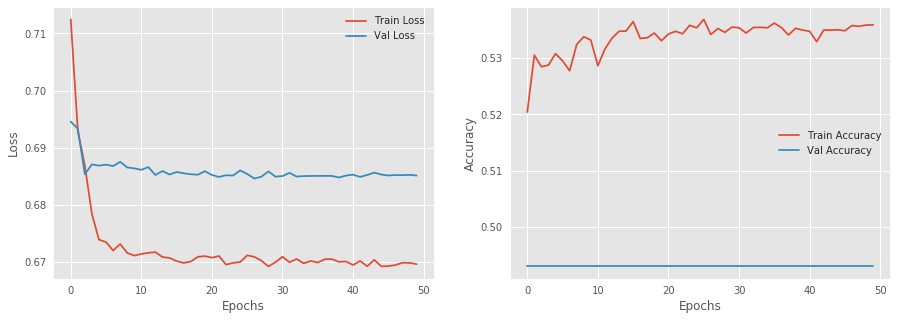

In [28]:
plot_loss_and_accuracy(history)

In [29]:
predictions = dense_model2.predict_classes(X_test).flatten()
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.447


In [30]:
predictions_full = dense_model2.predict_classes(X).flatten()
print('Accuracy : %.3f'%accuracy_score(Y, predictions_full))

Accuracy : 0.531


In [31]:
probs = dense_model2.predict_proba(X).flatten()
probs[:10]

array([0.48565596, 0.48544386, 0.48562706, 0.48571953, 0.19628564,
       0.4855984 , 0.48568735, 0.48553413, 0.48554644, 0.4857543 ],
      dtype=float32)

/home/sunny/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification Report : 
               precision    recall  f1-score   support

           0       0.45      1.00      0.62       451
           1       0.00      0.00      0.00       559

    accuracy                           0.45      1010
   macro avg       0.22      0.50      0.31      1010
weighted avg       0.20      0.45      0.28      1010

Confusion Matrix : 
 [[451   0]
 [559   0]]


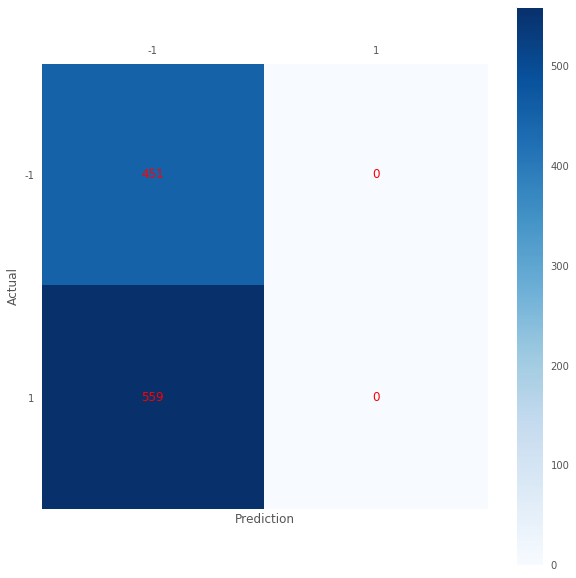

In [32]:
print_plot_metrics('DenseNetv2', Y_test, predictions)

In [33]:
print_weights_per_layer(dense_model2)

Layer : Dense : Weights : (636, 2048)
Layer : Dense : Bias : (2048,)
Layer : Dense : Weights : (2048, 1024)
Layer : Dense : Bias : (1024,)
Layer : Dense : Weights : (1024, 512)
Layer : Dense : Bias : (512,)
Layer : Dense : Weights : (512, 256)
Layer : Dense : Bias : (256,)
Layer : Dense : Weights : (256, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 1)
Layer : Dense : Bias : (1,)


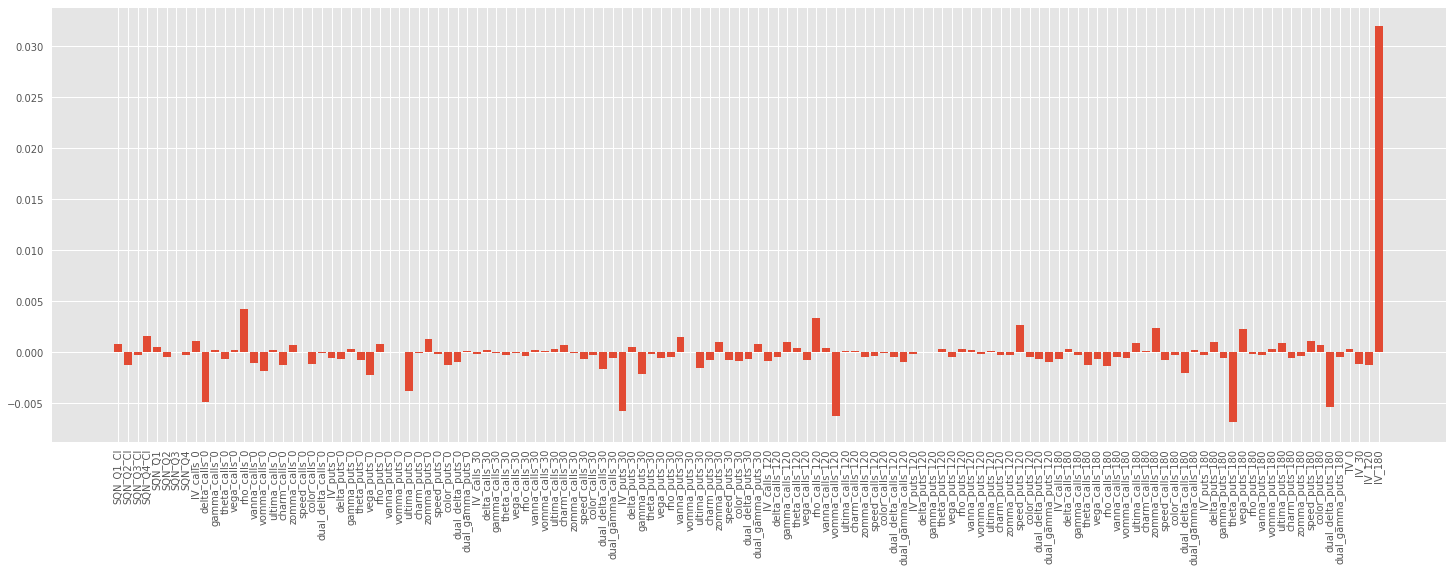

In [34]:
dense_weights = dense_model2.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[505:], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_dense_v2.png"), dpi=200)

In [35]:
dense_model2.save(os.path.join(batch,"dense_classifier_v2.h5"))

In [36]:
dense_model2 = load_model(os.path.join(batch,"dense_classifier_v2.h5"))

dense_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2048)              1304576   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

In [37]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, dense_model2)

probs[:5], labels[:5]

(array([0.48564565, 0.48578596, 0.48573077, 0.48566374, 0.48566377],
       dtype=float32), array([-1, -1, -1, -1, -1]))

In [38]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, dense_model1)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["DenseV2_Probs"] = tot_probs
combined_df_final["DenseV2_Preds"] = tot_labels

## 3. XGB Classifier

In [39]:
xgb_classif = xgb.XGBRFClassifier(n_estimators=500, max_depth=10, objective='binary:logistic', verbosity=1)

In [40]:
xgb_classif.fit(X_train, Y_train)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=10, min_child_weight=1, missing=None,
                n_estimators=500, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

In [41]:
predictions = xgb_classif.predict(X_test)
print('Accuracy : %.3f'%accuracy_score(Y_test, predictions))

Accuracy : 0.539


Classification Report : 
               precision    recall  f1-score   support

           0       0.49      0.65      0.56       451
           1       0.61      0.45      0.52       559

    accuracy                           0.54      1010
   macro avg       0.55      0.55      0.54      1010
weighted avg       0.56      0.54      0.54      1010

Confusion Matrix : 
 [[294 157]
 [309 250]]


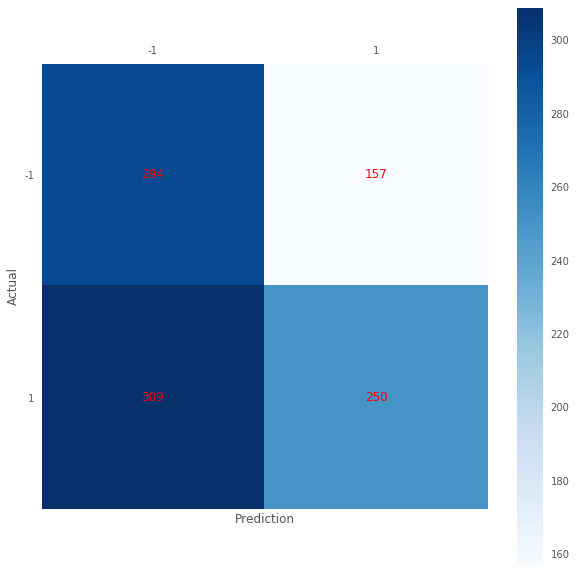

In [42]:
print_plot_metrics('XGB', Y_test, predictions)

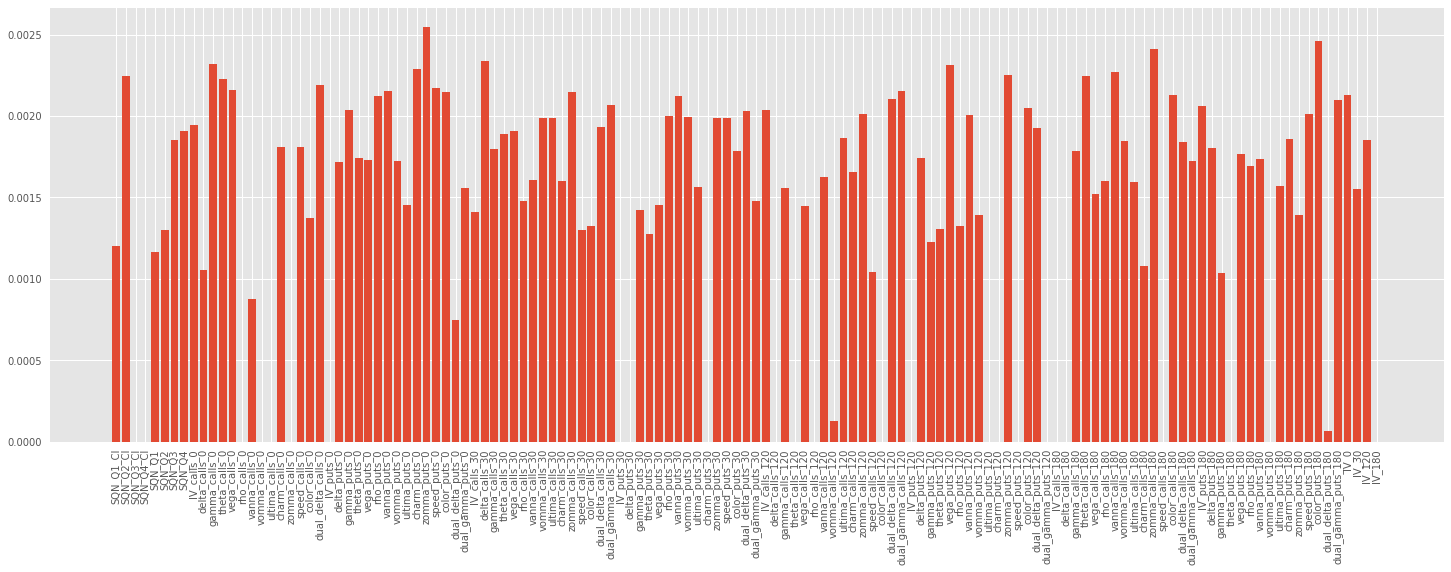

In [43]:
with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=xgb_classif.feature_importances_[505:], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_xgb.png"), dpi=200)

In [44]:
probs = xgb_classif.predict_proba(X_test)
probs = probs[:, 1]

probs[:5]

array([0.48817325, 0.5483166 , 0.46227998, 0.53152746, 0.46389502],
      dtype=float32)

In [45]:
pickle.dump(xgb_classif, open(os.path.join(batch,"xgb_classif.pkl"), "wb"))

xgb_classif_loaded = pickle.load(open(os.path.join(batch,"xgb_classif.pkl"), "rb"))

xgb_classif_loaded

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=10, min_child_weight=1, missing=nan, n_estimators=500,
                n_jobs=1, nthread=None, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=None, subsample=0.8, verbosity=1)

In [46]:
probs = xgb_classif_loaded.predict_proba(X_test)
probs = probs[:, 1]

probs[:5]

array([0.48817325, 0.5483166 , 0.46227998, 0.53152746, 0.46389502],
      dtype=float32)

In [47]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    df = df.fillna(value=0)

    data = df.values

    prediction_probs = model.predict_proba(data)
    prediction_probs = prediction_probs[:,1]
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

probs, labels = future_predictions(last_file, xgb_classif)

probs[:5], labels[:5]

(array([0.53573376, 0.4865347 , 0.46219668, 0.48856896, 0.50009817],
       dtype=float32), array([ 1, -1, -1, -1,  1]))

In [48]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, xgb_classif)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["XGB_Probs"] = tot_probs
combined_df_final["XGB_Preds"] = tot_labels

## 4. LSTM V1

In [49]:
total_data, labels = [], []

for file in sorted(os.listdir(os.path.join(base_folder, project_folder))):
    df = pd.read_csv(os.path.join(base_folder, project_folder, file))
    labels.append([1 if ret==1 else 0 for ret in df["returns"].values.tolist()])
    df = pd.get_dummies(df.fillna(value=0).drop(columns=["returns"]), columns=["ticker"])
    total_data.append(df.values.tolist())
    
    
total_data = np.array(total_data)
labels = np.array(labels)

print(total_data.shape, labels.shape)

(52, 505, 636) (52, 505)


In [50]:
X_train, X_test = total_data[:49], total_data[49:]
Y_train, Y_test = labels[:49], labels[49:]

X_train, X_test = X_train[:-1], X_test[:-1]
Y_train, Y_test = Y_train[1:], Y_test[1:]

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((48, 505, 636), (2, 505, 636), (48, 505), (2, 505))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                137400    
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 505)               25755     
Total params: 163,155
Trainable params: 163,155
Non-trainable params: 0
_________________________________________________________________
None


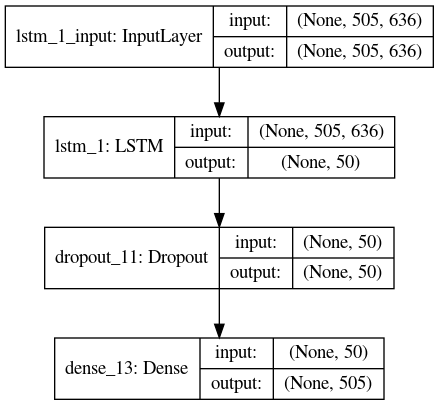

In [51]:
lstm_classif_v1 = Sequential([
                        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
                        Dropout(0.3),
                        Dense(Y_train.shape[1], activation='sigmoid')                        
                        ])

print(lstm_classif_v1.summary())

plot_model(lstm_classif_v1, to_file=os.path.join(batch, 'lstm_classif1.png'), show_shapes=True)
Image.open(os.path.join(batch, 'lstm_classif1.png'))

In [52]:
lstm_classif_v1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
history = lstm_classif_v1.fit(X_train, Y_train, epochs=50, batch_size=1, validation_split=0.1, verbose=2, shuffle=False)

Train on 43 samples, validate on 5 samples
Epoch 1/50
 - 7s - loss: 0.6922 - accuracy: 0.5189 - val_loss: 0.6890 - val_accuracy: 0.5196
Epoch 2/50
 - 5s - loss: 0.6803 - accuracy: 0.5537 - val_loss: 0.6892 - val_accuracy: 0.5200
Epoch 3/50
 - 5s - loss: 0.6707 - accuracy: 0.5697 - val_loss: 0.6893 - val_accuracy: 0.5220
Epoch 4/50
 - 5s - loss: 0.6641 - accuracy: 0.5783 - val_loss: 0.6898 - val_accuracy: 0.5275
Epoch 5/50
 - 5s - loss: 0.6603 - accuracy: 0.5830 - val_loss: 0.6884 - val_accuracy: 0.5339
Epoch 6/50
 - 5s - loss: 0.6545 - accuracy: 0.5911 - val_loss: 0.6918 - val_accuracy: 0.5244
Epoch 7/50
 - 5s - loss: 0.6522 - accuracy: 0.5922 - val_loss: 0.6898 - val_accuracy: 0.5299
Epoch 8/50
 - 5s - loss: 0.6516 - accuracy: 0.5935 - val_loss: 0.6915 - val_accuracy: 0.5283
Epoch 9/50
 - 5s - loss: 0.6489 - accuracy: 0.5993 - val_loss: 0.6916 - val_accuracy: 0.5347
Epoch 10/50
 - 5s - loss: 0.6467 - accuracy: 0.5964 - val_loss: 0.6916 - val_accuracy: 0.5315
Epoch 11/50
 - 5s - loss: 

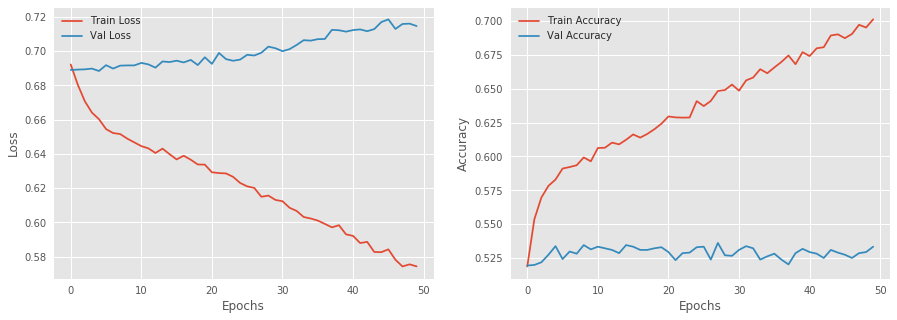

In [54]:
plot_loss_and_accuracy(history)

In [55]:
predictions = lstm_classif_v1.predict(X_test)
predictions_labels = np.where(predictions > 0.5, 1, 0)

print('Accuracy : %.3f'%accuracy_score(Y_test.flatten(), predictions_labels.flatten()))

Accuracy : 0.548


Classification Report : 
               precision    recall  f1-score   support

           0       0.49      0.64      0.56       451
           1       0.62      0.48      0.54       559

    accuracy                           0.55      1010
   macro avg       0.56      0.56      0.55      1010
weighted avg       0.56      0.55      0.55      1010

Confusion Matrix : 
 [[287 164]
 [293 266]]


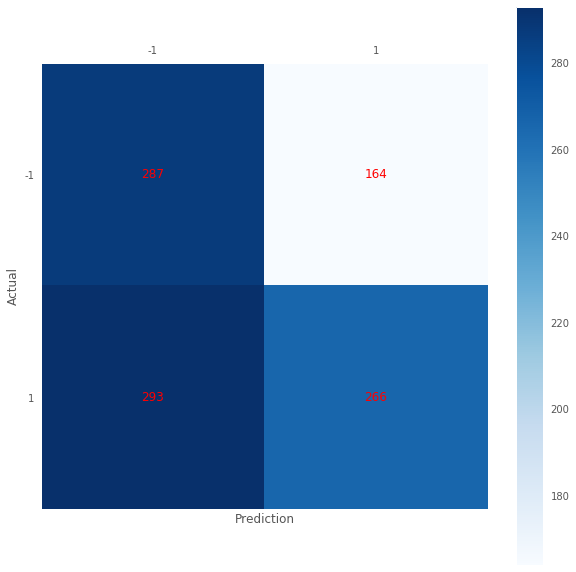

In [56]:
print_plot_metrics('LSTMV1', Y_test.flatten(), predictions_labels.flatten())

In [57]:
print_weights_per_layer(lstm_classif_v1)

Layer : LSTM : Weights : (636, 200)
Layer : Dense : Weights : (50, 200)
Layer : Dense : Bias : (200,)


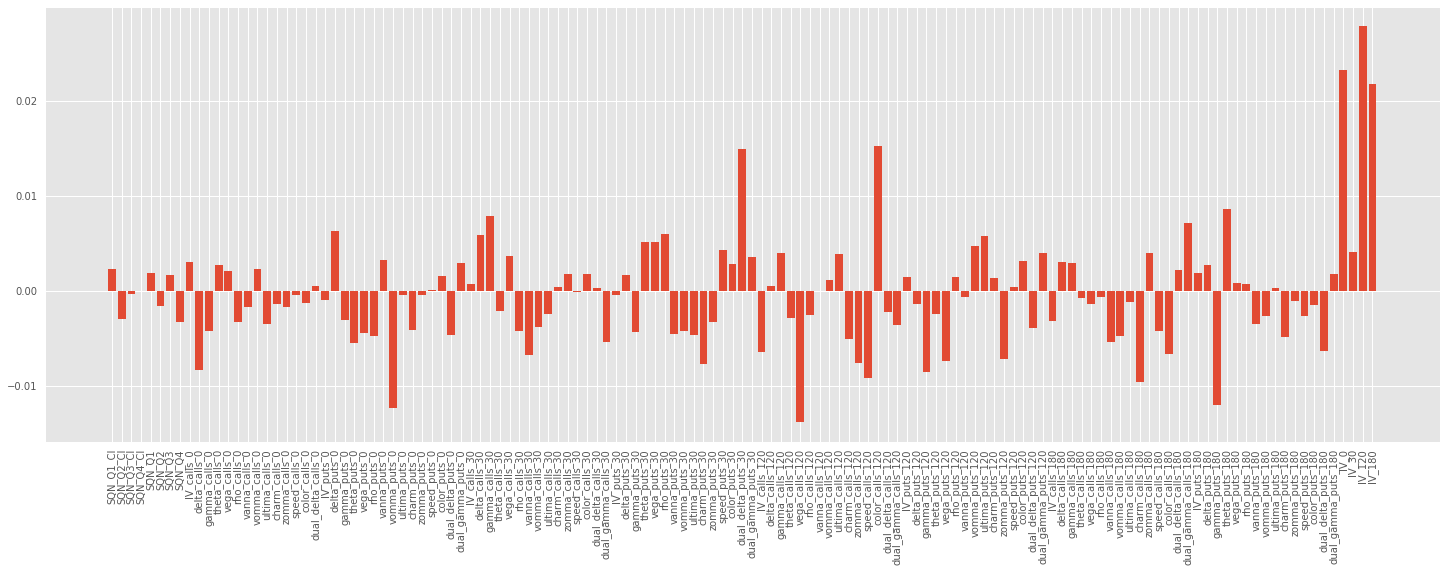

In [58]:
lstm_weights = lstm_classif_v1.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[505:], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_lstm_v1.png"), dpi=200)

In [59]:
lstm_classif_v1.save(os.path.join(batch,"lstm_classifier_v1.h5"))

In [60]:
lstm_classif_v1 = load_model(os.path.join(batch,"lstm_classifier_v1.h5"))

lstm_classif_v1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                137400    
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 505)               25755     
Total params: 163,155
Trainable params: 163,155
Non-trainable params: 0
_________________________________________________________________


In [61]:
def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    df = df.fillna(value=0)

    data = df.values
    data = data.reshape((1, data.shape[0], data.shape[1]))

    prediction_probs = model.predict(data).flatten()
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

In [62]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, lstm_classif_v1)

probs[:5], labels[:5]

(array([0.37501654, 0.52297616, 0.40291548, 0.6128957 , 0.5142444 ],
       dtype=float32), array([-1,  1, -1,  1,  1]))

In [63]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, lstm_classif_v1)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["LSTM_V1_Probs"] = tot_probs
combined_df_final["LSTM_V1_Preds"] = tot_labels

## 5. LSTM V2

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 505, 30)           80040     
_________________________________________________________________
lstm_3 (LSTM)                (None, 505, 30)           7320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_14 (Dense)             (None, 505)               15655     
Total params: 110,335
Trainable params: 110,335
Non-trainable params: 0
_________________________________________________________________
None


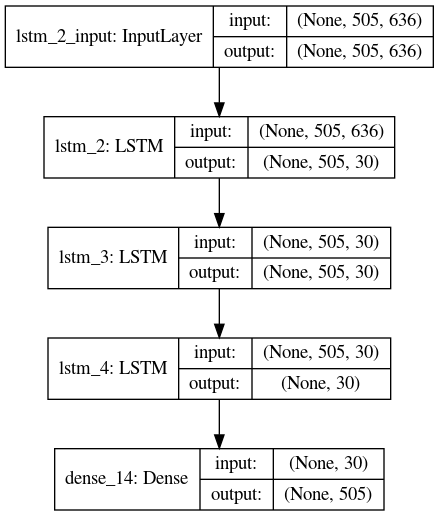

In [64]:
lstm_classif_v2 = Sequential([
                LSTM(units=30, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])),
                LSTM(units=30, return_sequences=True),
                LSTM(units=30),
                Dense(Y_train.shape[1], activation='sigmoid')
                ])

print(lstm_classif_v2.summary())

plot_model(lstm_classif_v2, to_file=os.path.join(batch, 'lstm_classif2.png'), show_shapes=True)
Image.open(os.path.join(batch, 'lstm_classif2.png'))

In [65]:
lstm_classif_v2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
history = lstm_classif_v2.fit(X_train, Y_train, epochs=50, batch_size=1, validation_split=0.1, verbose=2, shuffle=False)

Train on 43 samples, validate on 5 samples
Epoch 1/50
 - 10s - loss: 0.6909 - accuracy: 0.5206 - val_loss: 0.6898 - val_accuracy: 0.5200
Epoch 2/50
 - 9s - loss: 0.6767 - accuracy: 0.5596 - val_loss: 0.6891 - val_accuracy: 0.5212
Epoch 3/50
 - 9s - loss: 0.6663 - accuracy: 0.5725 - val_loss: 0.6919 - val_accuracy: 0.5248
Epoch 4/50
 - 9s - loss: 0.6634 - accuracy: 0.5761 - val_loss: 0.6929 - val_accuracy: 0.5275
Epoch 5/50
 - 9s - loss: 0.6624 - accuracy: 0.5788 - val_loss: 0.6933 - val_accuracy: 0.5255
Epoch 6/50
 - 9s - loss: 0.6620 - accuracy: 0.5809 - val_loss: 0.6934 - val_accuracy: 0.5263
Epoch 7/50
 - 9s - loss: 0.6616 - accuracy: 0.5825 - val_loss: 0.6935 - val_accuracy: 0.5271
Epoch 8/50
 - 9s - loss: 0.6614 - accuracy: 0.5831 - val_loss: 0.6936 - val_accuracy: 0.5267
Epoch 9/50
 - 9s - loss: 0.6612 - accuracy: 0.5833 - val_loss: 0.6936 - val_accuracy: 0.5267
Epoch 10/50
 - 9s - loss: 0.6611 - accuracy: 0.5834 - val_loss: 0.6937 - val_accuracy: 0.5259
Epoch 11/50
 - 9s - loss:

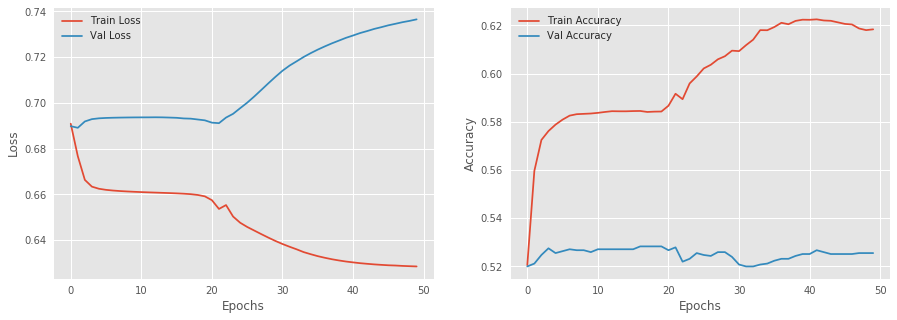

In [67]:
plot_loss_and_accuracy(history)

In [68]:
predictions = lstm_classif_v2.predict(X_test)
predictions_labels = np.where(predictions > 0.5, 1, 0)

print('Accuracy : %.3f'%accuracy_score(Y_test.flatten(), predictions_labels.flatten()))

Accuracy : 0.550


Classification Report : 
               precision    recall  f1-score   support

           0       0.50      0.62      0.55       451
           1       0.62      0.50      0.55       559

    accuracy                           0.55      1010
   macro avg       0.56      0.56      0.55      1010
weighted avg       0.56      0.55      0.55      1010

Confusion Matrix : 
 [[278 173]
 [282 277]]


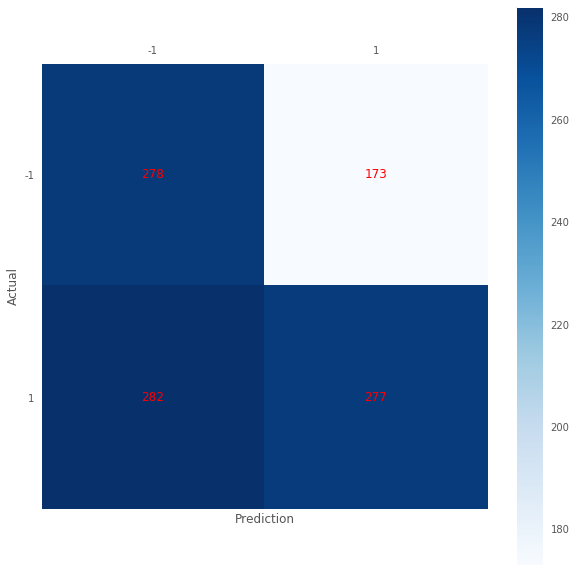

In [69]:
print_plot_metrics('LSTMV2', Y_test.flatten(), predictions_labels.flatten())

In [70]:
print_weights_per_layer(lstm_classif_v2)

Layer : LSTM : Weights : (636, 120)
Layer : LSTM : Weights : (30, 120)
Layer : LSTM : Weights : (120,)
Layer : Dense : Weights : (30, 120)
Layer : Dense : Bias : (30, 120)


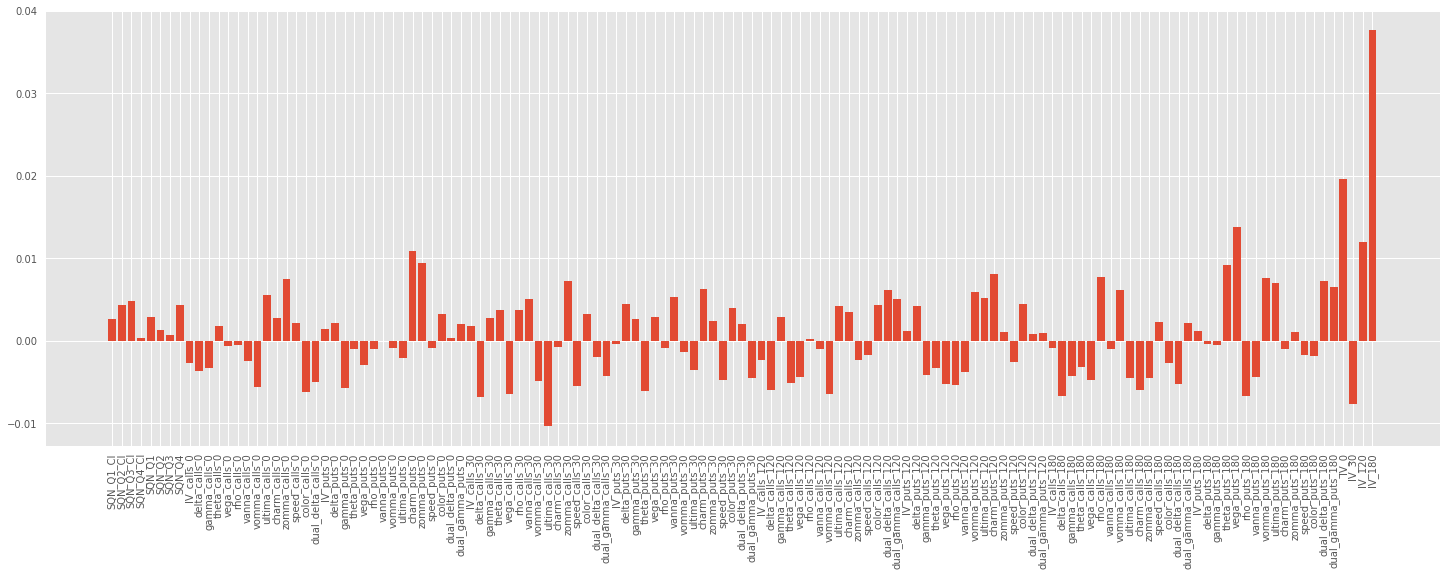

In [71]:
lstm_weights = lstm_classif_v2.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[505:], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_lstm_v2.png"), dpi=200)

In [72]:
lstm_classif_v2.save(os.path.join(batch,"lstm_classifier_v2.h5"))

In [73]:
lstm_classif_v2 = load_model(os.path.join(batch,"lstm_classifier_v2.h5"))

lstm_classif_v2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 505, 30)           80040     
_________________________________________________________________
lstm_3 (LSTM)                (None, 505, 30)           7320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_14 (Dense)             (None, 505)               15655     
Total params: 110,335
Trainable params: 110,335
Non-trainable params: 0
_________________________________________________________________


In [74]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, lstm_classif_v2)

probs[:5], labels[:5]

(array([0.62934685, 0.55070174, 0.35764012, 0.6327824 , 0.39241788],
       dtype=float32), array([ 1,  1, -1,  1, -1]))

In [75]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, lstm_classif_v2)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["LSTM_V2_Probs"] = tot_probs
combined_df_final["LSTM_V2_Preds"] = tot_labels

## 6. CNN LSTM

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 505, 64)     40768     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 252, 64)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 16128)       0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                3235800   
_________________________________________________________________
dense_15 (Dense)             (None, 505)               25755     
Total params: 3,302,323
Trainable params: 3,302,323
Non-trainable params: 0
_________________________________________________________________
None


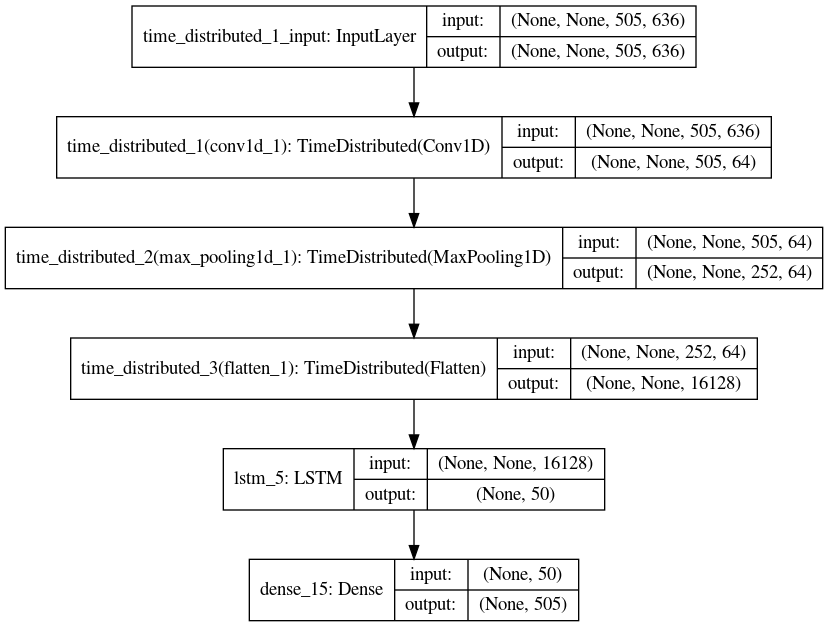

In [76]:
lstm_classif_v3 = Sequential([
    TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train.shape[1], X_train.shape[2])),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(50, activation='relu'),
    Dense(Y_train.shape[1], activation='sigmoid')
])


print(lstm_classif_v3.summary())

plot_model(lstm_classif_v3, to_file=os.path.join(batch, 'lstm_classif3.png'), show_shapes=True)
Image.open(os.path.join(batch, 'lstm_classif3.png'))

In [77]:
lstm_classif_v3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [78]:
history = lstm_classif_v3.fit(X_train.reshape(X_train.shape[0],1,X_train.shape[1], X_train.shape[2]), Y_train, epochs=50, batch_size=1, validation_split=0.1, verbose=2, shuffle=False)

Train on 43 samples, validate on 5 samples
Epoch 1/50
 - 4s - loss: 0.7131 - accuracy: 0.5256 - val_loss: 0.6926 - val_accuracy: 0.5137
Epoch 2/50
 - 2s - loss: 0.6916 - accuracy: 0.5636 - val_loss: 0.6920 - val_accuracy: 0.5160
Epoch 3/50
 - 2s - loss: 0.6901 - accuracy: 0.5803 - val_loss: 0.6915 - val_accuracy: 0.5232
Epoch 4/50
 - 2s - loss: 0.6889 - accuracy: 0.5821 - val_loss: 0.6910 - val_accuracy: 0.5228
Epoch 5/50
 - 2s - loss: 0.6878 - accuracy: 0.5837 - val_loss: 0.6905 - val_accuracy: 0.5240
Epoch 6/50
 - 2s - loss: 0.6867 - accuracy: 0.5833 - val_loss: 0.6901 - val_accuracy: 0.5240
Epoch 7/50
 - 2s - loss: 0.6856 - accuracy: 0.5839 - val_loss: 0.6896 - val_accuracy: 0.5263
Epoch 8/50
 - 2s - loss: 0.6846 - accuracy: 0.5841 - val_loss: 0.6893 - val_accuracy: 0.5267
Epoch 9/50
 - 2s - loss: 0.6836 - accuracy: 0.5844 - val_loss: 0.6889 - val_accuracy: 0.5267
Epoch 10/50
 - 2s - loss: 0.6826 - accuracy: 0.5853 - val_loss: 0.6886 - val_accuracy: 0.5267
Epoch 11/50
 - 2s - loss: 

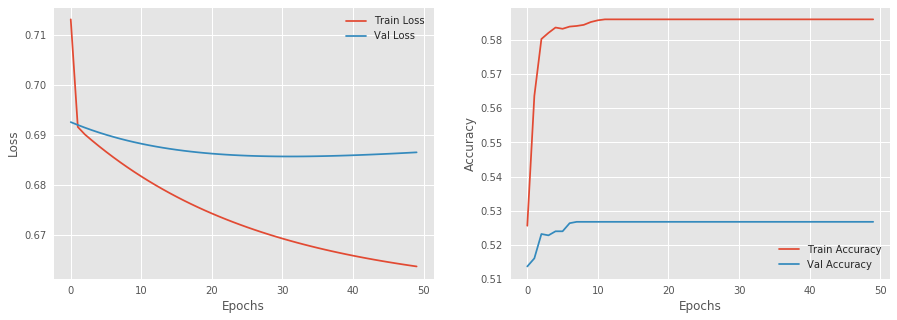

In [79]:
plot_loss_and_accuracy(history)

In [80]:
predictions = lstm_classif_v3.predict(X_test.reshape(X_test.shape[0],1,X_test.shape[1], X_test.shape[2]))
predictions_labels = np.where(predictions > 0.5, 1, 0)

print('Accuracy : %.3f'%accuracy_score(Y_test.flatten(), predictions_labels.flatten()))

Accuracy : 0.508


Classification Report : 
               precision    recall  f1-score   support

           0       0.46      0.65      0.54       451
           1       0.58      0.40      0.47       559

    accuracy                           0.51      1010
   macro avg       0.52      0.52      0.51      1010
weighted avg       0.53      0.51      0.50      1010

Confusion Matrix : 
 [[292 159]
 [338 221]]


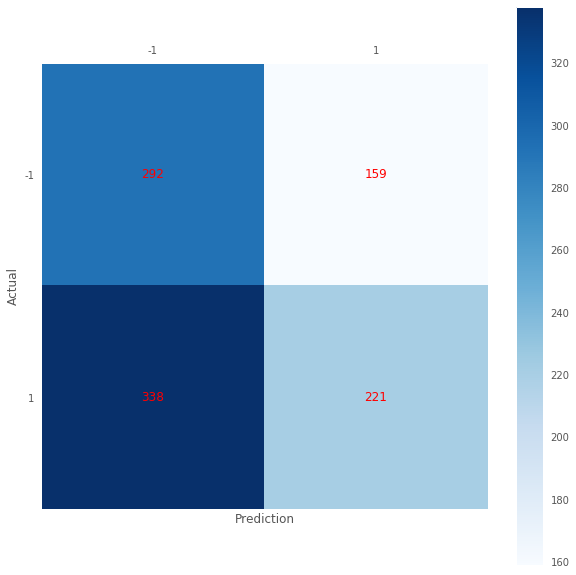

In [81]:
print_plot_metrics('LSTMV3', Y_test.flatten(), predictions_labels.flatten())

In [82]:
print_weights_per_layer(lstm_classif_v3)

Layer : TimeDistributed : Weights : (1, 636, 64)
Layer : TimeDistributed : Weights : (64,)
Layer : TimeDistributed : Weights : (16128, 200)
Layer : LSTM : Weights : (50, 200)
Layer : Dense : Weights : (200,)
Layer : Dense : Bias : (50, 505)


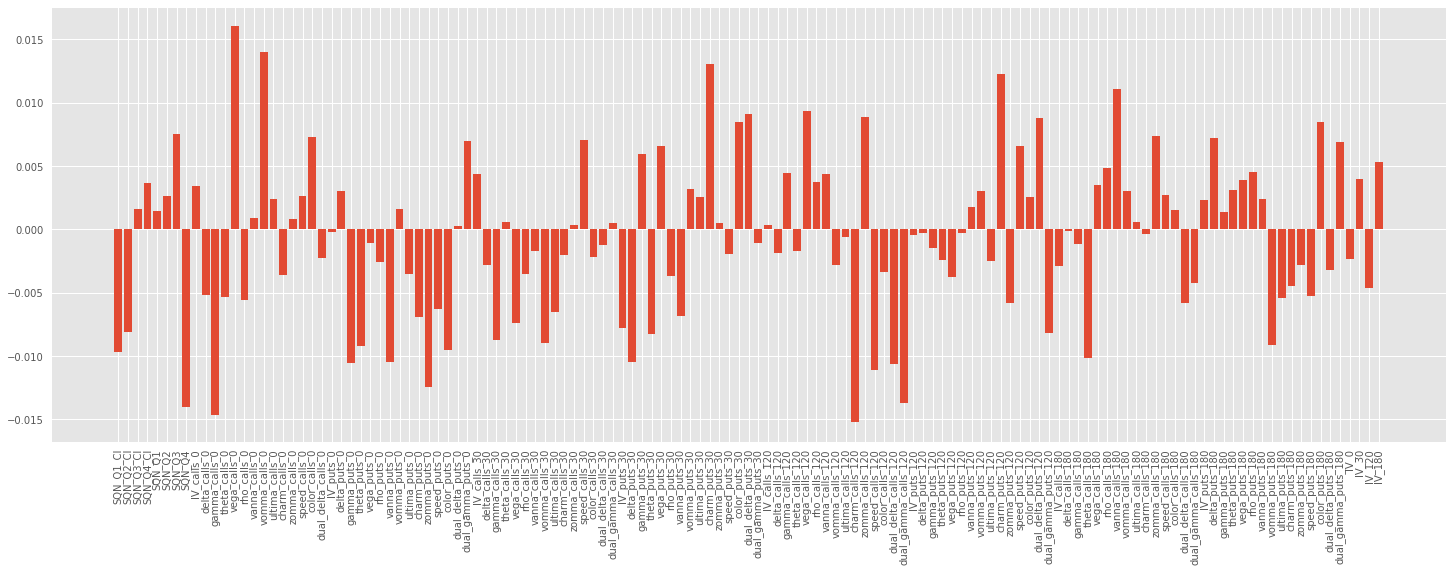

In [83]:
lstm_weights = lstm_classif_v3.get_weights()
important_weights = lstm_weights[0].mean(axis=2).flatten()

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[505:], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_lstm_v3.png"), dpi=200)

In [84]:
lstm_classif_v3.save(os.path.join(batch,"lstm_classifier_v3.h5"))

In [85]:
lstm_classif_v3 = load_model(os.path.join(batch,"lstm_classifier_v3.h5"))

lstm_classif_v3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 505, 64)     40768     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 252, 64)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 16128)       0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                3235800   
_________________________________________________________________
dense_15 (Dense)             (None, 505)               25755     
Total params: 3,302,323
Trainable params: 3,302,323
Non-trainable params: 0
_________________________________________________________________


In [86]:
def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    df = df.fillna(value=0)

    data = df.values
    data = data.reshape((1, 1, data.shape[0], data.shape[1]))

    prediction_probs = model.predict(data).flatten()
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

In [87]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, lstm_classif_v3)

probs[:5], labels[:5]

(array([0.5383421 , 0.49190786, 0.50790524, 0.5844929 , 0.4617326 ],
       dtype=float32), array([ 1, -1,  1,  1, -1]))

In [88]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, lstm_classif_v3)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["LSTM_V3_Probs"] = tot_probs
combined_df_final["LSTM_V3_Preds"] = tot_labels

## 7. ConvLSTM

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 504, 64)        358656    
_________________________________________________________________
flatten_2 (Flatten)          (None, 32256)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 505)               16289785  
Total params: 16,648,441
Trainable params: 16,648,441
Non-trainable params: 0
_________________________________________________________________
None


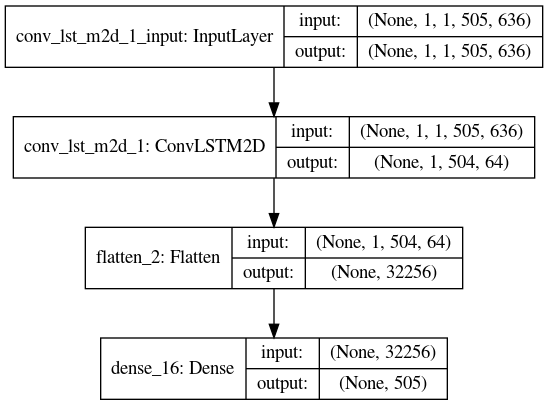

In [89]:
lstm_classif_v4 = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(1, 1, X_train.shape[1], X_train.shape[2])),
    Flatten(),
    Dense(Y_train.shape[1], activation='sigmoid')
])


print(lstm_classif_v4.summary())

plot_model(lstm_classif_v4, to_file=os.path.join(batch, 'lstm_classif4.png'), show_shapes=True)
Image.open(os.path.join(batch, 'lstm_classif4.png'))

In [90]:
lstm_classif_v4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [91]:
history = lstm_classif_v4.fit(X_train.reshape(X_train.shape[0],1, 1, X_train.shape[1], X_train.shape[2]), Y_train, epochs=50, batch_size=1, validation_split=0.1, verbose=2, shuffle=False)

Train on 43 samples, validate on 5 samples
Epoch 1/50
 - 30s - loss: 0.7100 - accuracy: 0.5297 - val_loss: 0.6857 - val_accuracy: 0.5204
Epoch 2/50
 - 12s - loss: 0.6542 - accuracy: 0.5964 - val_loss: 0.6907 - val_accuracy: 0.5248
Epoch 3/50
 - 12s - loss: 0.6279 - accuracy: 0.6344 - val_loss: 0.6859 - val_accuracy: 0.5382
Epoch 4/50
 - 11s - loss: 0.5825 - accuracy: 0.6836 - val_loss: 0.7006 - val_accuracy: 0.5303
Epoch 5/50
 - 11s - loss: 0.5101 - accuracy: 0.7519 - val_loss: 0.7451 - val_accuracy: 0.5307
Epoch 6/50
 - 11s - loss: 0.4190 - accuracy: 0.8132 - val_loss: 0.7737 - val_accuracy: 0.5248
Epoch 7/50
 - 11s - loss: 0.3304 - accuracy: 0.8666 - val_loss: 0.8634 - val_accuracy: 0.5192
Epoch 8/50
 - 12s - loss: 0.1757 - accuracy: 0.9443 - val_loss: 1.0338 - val_accuracy: 0.5172
Epoch 9/50
 - 11s - loss: 0.1188 - accuracy: 0.9660 - val_loss: 1.4747 - val_accuracy: 0.5034
Epoch 10/50
 - 11s - loss: 0.0490 - accuracy: 0.9876 - val_loss: 1.8792 - val_accuracy: 0.5101
Epoch 11/50
 - 1

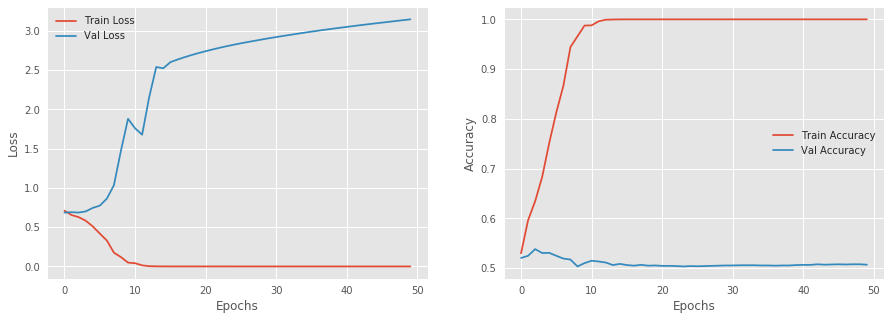

In [92]:
plot_loss_and_accuracy(history)

In [93]:
predictions = lstm_classif_v4.predict(X_test.reshape(X_test.shape[0],1,1,X_test.shape[1], X_test.shape[2]))
predictions_labels = np.where(predictions > 0.5, 1, 0)

print('Accuracy : %.3f'%accuracy_score(Y_test.flatten(), predictions_labels.flatten()))

Accuracy : 0.522


Classification Report : 
               precision    recall  f1-score   support

           0       0.47      0.59      0.52       451
           1       0.58      0.47      0.52       559

    accuracy                           0.52      1010
   macro avg       0.53      0.53      0.52      1010
weighted avg       0.53      0.52      0.52      1010

Confusion Matrix : 
 [[264 187]
 [296 263]]


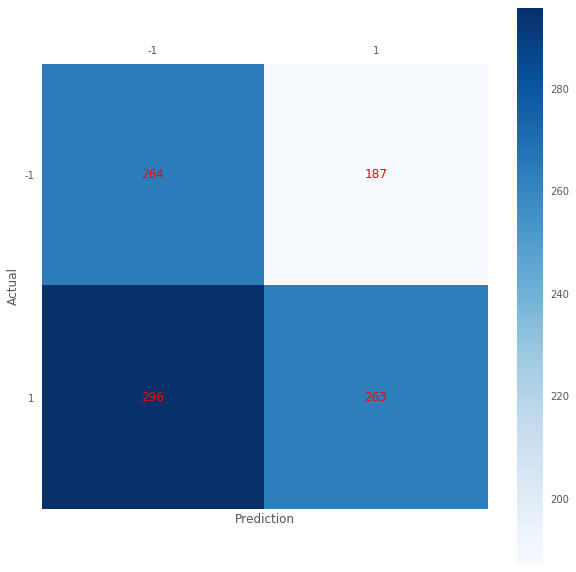

In [94]:
print_plot_metrics('LSTMV4', Y_test.flatten(), predictions_labels.flatten())

In [95]:
print_weights_per_layer(lstm_classif_v4)

Layer : ConvLSTM2D : Weights : (1, 2, 636, 256)
Layer : Flatten : Weights : (1, 2, 64, 256)
Layer : Dense : Weights : (256,)
Layer : Dense : Bias : (32256, 505)


(1, 2, 636, 256)


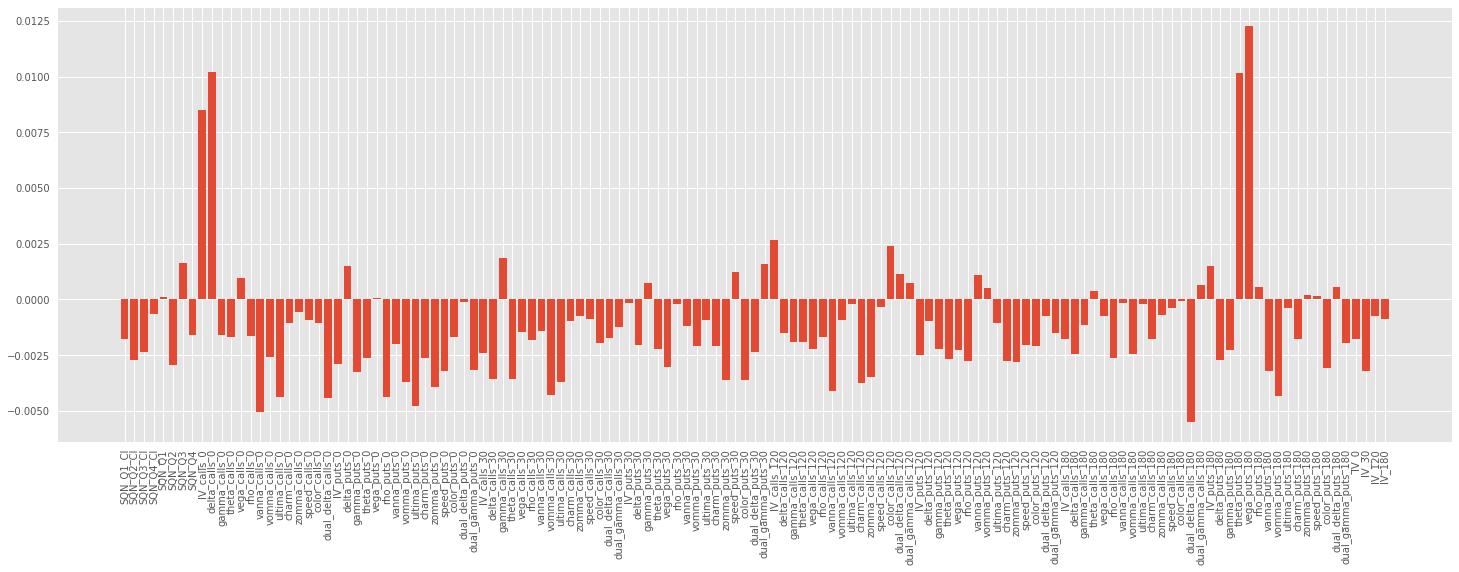

In [96]:
lstm_weights = lstm_classif_v4.get_weights()
print(lstm_weights[0].shape)
important_weights = lstm_weights[0].mean(axis=3).mean(axis=1).flatten()

with plt.style.context(('seaborn','ggplot')):
    plt.figure(figsize=(25,8))
    plt.bar(x=combined_df.drop(columns=["ticker", "returns"]).columns, height=important_weights[505:], width=0.8)
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(batch, "weights_lstm_v4.png"), dpi=200)

In [97]:
lstm_classif_v4.save(os.path.join(batch,"lstm_classifier_v4.h5"))

In [98]:
lstm_classif_v4 = load_model(os.path.join(batch,"lstm_classifier_v4.h5"))

lstm_classif_v4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 504, 64)        358656    
_________________________________________________________________
flatten_2 (Flatten)          (None, 32256)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 505)               16289785  
Total params: 16,648,441
Trainable params: 16,648,441
Non-trainable params: 0
_________________________________________________________________


In [99]:
def future_predictions(file_name, model):
    df = pd.read_csv(file_name)
    df = pd.get_dummies(df.drop(columns=["returns"]), columns=["ticker"])
    df = df.fillna(value=0)

    data = df.values
    data = data.reshape((1, 1, 1, data.shape[0], data.shape[1]))

    prediction_probs = model.predict(data).flatten()
    prediction_labels = np.where(prediction_probs > 0.5, 1, -1)
    
    return prediction_probs, prediction_labels

In [100]:
last_file = sorted(os.listdir(os.path.join(base_folder, project_folder)))[-1]
last_file = os.path.join(base_folder, project_folder, last_file)

probs, labels = future_predictions(last_file, lstm_classif_v4)

probs[:5], labels[:5]

(array([0.00890529, 0.9999966 , 0.28779772, 0.9999554 , 0.02596891],
       dtype=float32), array([-1,  1, -1,  1, -1]))

In [101]:
tot_probs, tot_labels = [0]* 505, [0]*505
for file_name in sorted(os.listdir(os.path.join(base_folder, project_folder)))[:-1]:
    file_name = os.path.join(base_folder, project_folder, file_name)
    probs, labels = future_predictions(file_name, lstm_classif_v4)
    tot_probs.extend(probs)
    tot_labels.extend(labels)
    
combined_df_final["LSTM_V4_Probs"] = tot_probs
combined_df_final["LSTM_V4_Preds"] = tot_labels

## Writing Final CSV With Probs & Predicted Labels to Disk

In [102]:
combined_df_final.tail()

,ticker,SQN_Q1_CI,SQN_Q2_CI,SQN_Q3_CI,SQN_Q4_CI,SQN_Q1,SQN_Q2,SQN_Q3,SQN_Q4,IV_calls_0,...,XGB_Probs,XGB_Preds,LSTM_V1_Probs,LSTM_V1_Preds,LSTM_V2_Probs,LSTM_V2_Preds,LSTM_V3_Probs,LSTM_V3_Preds,LSTM_V4_Probs,LSTM_V4_Preds
500,YUM,3.0,1.0,1.0,5.0,3.0,1.0,1.0,5.0,4.0,...,0.489363,-1,0.562277,1,0.373983,-1,0.523158,1,9.881570e-01,1
501,ZBH,3.0,1.0,5.0,3.0,3.0,2.0,5.0,3.0,4.0,...,0.498528,-1,0.431286,-1,0.281809,-1,0.415872,-1,3.576279e-07,-1
502,ZBRA,2.0,2.0,4.0,1.0,2.0,2.0,3.0,1.0,1.0,...,0.523154,1,0.472154,-1,0.458234,-1,0.477044,-1,9.896546e-01,1
503,ZION,3.0,4.0,5.0,1.0,3.0,4.0,5.0,1.0,3.0,...,0.569315,1,0.431355,-1,0.609274,1,0.492153,-1,9.993657e-01,1
504,ZTS,2.0,1.0,1.0,5.0,2.0,1.0,1.0,5.0,4.0,...,0.505240,1,0.683071,1,0.560719,1,0.399568,-1,8.257523e-04,-1


In [103]:
combined_df_final.to_csv(os.path.join(batch,"final.csv"))